In [4]:
import numpy as np
import numpy as np
import torch
from torch_geometric.data import Data
from scipy.spatial.distance import cdist
import os
from tqdm import tqdm
from torch_geometric.utils import to_undirected
from torch_geometric.utils import is_undirected

signals_ocd = np.load('PVDM_OCD_ROI512.npz')
signals_hc = np.load('PVDM_HC_ROI512.npz')
coords = np.load('diffumo_coord_ROI512.npy')  # shape (128, 3)

# Functional Connectivity

In [5]:
import torch
import math

def get_sinusoidal_embedding(timestep, dim, device='cpu'):
    half_dim = dim // 2
    freq_scale = torch.exp(-torch.arange(half_dim, dtype=torch.float, device=device) * math.log(10000.0) / (half_dim - 1))
    angles = timestep * freq_scale
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=0)  # [dim]
    return emb  # shape: [dim]


In [23]:
from torch_geometric.data import Data
import torch
import numpy as np

def create_patient_fc_graphs_with_time(signal, label, time_dim=16, threshold=0.65):
    """
    Creates one functional connectivity structure from full signal,
    then creates one PyG graph per timepoint with signal + time embedding as node features.
    """
    T, N = signal.shape  # T = timepoints, N = ROIs

    # Functional connectivity across full session
    corr_matrix = np.corrcoef(signal.T)  # (N, N)
    np.fill_diagonal(corr_matrix, 0.0)   # zero out self-connections
    # print(corr_matrix)
    adj_matrix = (corr_matrix > threshold).astype(float)  # or use corr_matrix directly
    adj_tensor = torch.tensor(adj_matrix, dtype=torch.float)
    edge_index = adj_tensor.nonzero(as_tuple=True)
    edge_attr = adj_tensor[edge_index]

    graphs = []

    for t in range(T):
        signal_t = torch.tensor(signal[t], dtype=torch.float32).unsqueeze(-1)  # (N, 1)
        time_emb = get_sinusoidal_embedding(t, time_dim).unsqueeze(0).repeat(N, 1)  # (N, time_dim)
        x = torch.cat([signal_t, time_emb], dim=1)  # (N, 1 + time_dim)

        data = Data(
            x=x,
            edge_index=torch.stack(edge_index, dim=0),
            edge_attr=edge_attr,
            y=torch.tensor([label], dtype=torch.long),
            time=torch.tensor(t, dtype=torch.long)
        )
        graphs.append(data)

    return graphs


In [24]:
all_graphs = []

for dataset, label_str, label_val in [(signals_ocd, 'OCD', 1), (signals_hc, 'HC', 0)]:
    for patient_id in tqdm(dataset.files, desc=f'Processing {label_str} patients'):
        patient_data = dataset[patient_id]  # shape (2, T, N)
        signal_after = patient_data[1]      # shape (T, N)
        patient_graphs = create_patient_fc_graphs_with_time(
            signal_after, label=label_val, time_dim=16, threshold=0.65
        )
        # break
        all_graphs.extend(patient_graphs)


Processing HC patients: 100%|██████████| 28/28 [00:02<00:00, 10.55it/s]


In [25]:
all_graphs[0]

Data(x=[512, 17], edge_index=[2, 4656], edge_attr=[4656], y=[1], time=0)

In [26]:
# Save the graphs to a file
torch.save(all_graphs, 'all_graphs_FC.pt')

In [27]:
all_graphs[1]

Data(x=[512, 17], edge_index=[2, 4656], edge_attr=[4656], y=[1], time=1)

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch

# Function to visualize a graph using ROI anatomical coordinates
def visualize_graph(graph, disconnected_nodes=None, title="Graph Visualization"):
    G = to_networkx(graph, edge_attrs=["edge_attr"])
    G = G.to_undirected()

    # Extract coordinates from graph.pos → [num_nodes, 3]
    coords = graph.pos.cpu().numpy() if isinstance(graph.pos, torch.Tensor) else graph.pos
    pos = {i: coords[i, :2] for i in range(coords.shape[0])}  # Use only X-Y for 2D layout

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(
        G, pos, 
        nodelist=[n for n in G.nodes if n not in disconnected_nodes],
        node_size=30, node_color="lightblue", alpha=0.8
    )
    if disconnected_nodes:
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=disconnected_nodes, 
            node_size=30, node_color="red", alpha=0.8
        )
    nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.5, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=5)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Visualize first 3 graphs with anatomical layout and highlight disconnected nodes
for i in range(3):
    visualize_graph(all_graphs[i], disconnected_nodes=None, title=f"Graph {i+1}")


# Anatomical Connectivity

In [16]:
def compute_gaussian_edges(coords, sigma=9, threshold=5e-2):
    # coords: (128, 3)
    D = cdist(coords, coords, metric='euclidean')  # shape (128, 128)
    
    if sigma is None:
        sigma = np.median(D)  # reasonable default
    print(f'sigma: {sigma}')
    A = np.exp(- (D ** 2) / (2 * sigma ** 2))  # shape (128, 128)
    # Remove self-loops
    np.fill_diagonal(A, 0)
    density = (A > 2e-2).sum() / A.size
    print(density)
    # Zero out weak connections
    A[A < threshold] = 0.0
    
    # Get edge indices and weights
    edge_index = np.array(np.nonzero(A))  # shape (2, num_edges)
    edge_weight = A[edge_index[0], edge_index[1]]  # shape (num_edges,)
    
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    edge_index, edge_weight = to_undirected(edge_index, edge_attr=edge_weight)
    return edge_index, edge_weight

In [17]:
import torch
import math

def get_sinusoidal_embedding(timestep, dim, device='cpu'):
    half_dim = dim // 2
    freq_scale = torch.exp(-torch.arange(half_dim, dtype=torch.float, device=device) * math.log(10000.0) / (half_dim - 1))
    angles = timestep * freq_scale
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=0)  # [dim]
    return emb  # shape: [dim]


In [18]:
def create_graph(signal_t, coords, edge_index, edge_weight, label, t=None, time_dim=16):
    x = torch.tensor(signal_t, dtype=torch.float).unsqueeze(-1)  # [512, 1]

    if t is not None:
        time_emb = get_sinusoidal_embedding(
            timestep=t,
            dim=time_dim,
            device=x.device
        ).repeat(x.size(0), 1)  # [512, time_dim]
        x = torch.cat([x, time_emb], dim=1)  # [512, 1 + time_dim]

    pos = torch.tensor(coords, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    # print(x.shape)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, pos=pos, y=y)
    if t is not None:
        data.time = t
    return data


In [5]:
def create_graph(signal, coords, edge_index, edge_weight, label):
    x = torch.tensor(signal, dtype=torch.float).unsqueeze(-1)  # (420, ROIs)
    # x = x.transpose(0, 1)  # (ROIs, 420)
    pos = torch.tensor(coords, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)  # classification label
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, pos=pos, y=y)
    return data

Graphs for each 420 timepoints and 51 patients.

In [ ]:
import math
from tqdm import tqdm

all_graphs = []
edge_index, edge_weight = compute_gaussian_edges(coords)
time_dim = 16  # can tune this

for dataset, label_str, label_val in [(signals_ocd, 'OCD', 1), (signals_hc, 'HC', 0)]:
    for patient_id in tqdm(dataset.files, desc=f'Processing {label_str} patients'):
        patient_data = dataset[patient_id]  # shape (2, 420, ROIs)
        signal_after = patient_data[1]      # shape (420, 512)

        for t in range(signal_after.shape[0]):
            signal_t = signal_after[t]  # shape: (512,)
            graph_t = create_graph(
                signal_t, coords, edge_index, edge_weight,
                label=label_val, t=t, time_dim=time_dim
            )
            all_graphs.append(graph_t)


In [19]:
import pandas as pd

# # Load patient metadata
# metadata_df = pd.read_csv("metadata.csv")  # columns: imaging ID, sub, gender, Dx
# sub_to_gender = {row['sub']: 1 if row['gender'].strip().lower() == 'female' else 0 for _, row in metadata_df.iterrows()}

# Load Excel metadata
metadata_df = pd.read_excel("PVDM_sublist.xlsx")  # change path/filename

# Construct mapping from subject ID to gender
# Build mapping from imaging ID (e.g. 'pb7806') → gender label (0 = male, 1 = female)
id_to_gender = {
    row['imaging ID']: 1 if str(row['gender']).strip().lower() == 'female' else 0
    for _, row in metadata_df.iterrows()
}

all_graphs = []
edge_index, edge_weight = compute_gaussian_edges(coords)
time_dim = 16  # can tune this

for dataset, label_str, label_val in [(signals_ocd, 'OCD', 1), (signals_hc, 'HC', 0)]:
    for patient_id in tqdm(dataset.files, desc=f'Processing {label_str} patients'):
        patient_data = dataset[patient_id]  # shape (2, 420, ROIs)
        gender_label = id_to_gender.get(patient_id, None)
        assert gender_label is not None, f"Gender not found for {patient_id}"

        for t in range(patient_data.shape[1]):
            signal_t = patient_data[1, t]
            graph_t = create_graph(
                signal_t, coords, edge_index, edge_weight,
                label=label_val, t=t, time_dim=time_dim
            )
            graph_t.gender = torch.tensor([gender_label])  # add gender label
            all_graphs.append(graph_t)



sigma: 9
0.0299835205078125


Processing HC patients: 100%|██████████| 28/28 [00:02<00:00, 12.40it/s]


In [20]:
all_graphs

[Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=0, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=1, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=2, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=3, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=4, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=5, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=6, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=7, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=8, gender=[1]),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=9, gen

In [21]:
torch.save(all_graphs, 'all_graphs_MF.pt')
print(f"Saved {len(all_graphs)} graphs to 'all_graphs.pt'")

Saved 21316 graphs to 'all_graphs.pt'


In [7]:
all_graphs = []
edge_index, edge_weight = compute_gaussian_edges(coords)
for dataset, label_str, label_val in [(signals_ocd, 'OCD', 1), (signals_hc, 'HC', 0)]:
    # break
    for patient_id in tqdm(dataset.files, desc=f'Processing {label_str} patients'):
        patient_data = dataset[patient_id]  # shape (2, 420, ROIs)

        for t in range(patient_data.shape[1]):
            signal_after = patient_data[1, t]  # (ROIs,)
            graph_after = create_graph(signal_after, coords, edge_index, edge_weight, label_val)
            all_graphs.append(graph_after)

sigma: 9
0.0299835205078125


Processing HC patients: 100%|██████████| 28/28 [00:00<00:00, 37.84it/s]


In [8]:
all_graphs

[Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3]),
 Data(x=[512, 1], edge_index=[2, 5460], 

Graphs for each patient and continous timepoints 420

In [5]:
all_graphs = []
edge_index, edge_weight = compute_gaussian_edges(coords)

for dataset, label_str, label_val in [(signals_ocd, 'OCD', 1), (signals_hc, 'HC', 0)]:
    # break
    for patient_id in tqdm(dataset.files, desc=f'Processing {label_str} patients'):
        patient_data = dataset[patient_id]  # shape (2, 420, 128)

        # Only use the "after task" data: shape (420, 128)
        signal_after = patient_data[1]  # shape: (420, 128)
        # smoothed_signal_after = smooth_signals(signal_after, sigma=2)
        graph_after = create_graph(signal_after, coords, edge_index, edge_weight, label_val)
        all_graphs.append(graph_after)


sigma: 9
0.0299835205078125


Processing HC patients: 100%|██████████| 28/28 [00:00<00:00, 501.39it/s]


In [ ]:
all_graphs

In [225]:
import numpy as np

# Compute the median number of neighbors for nodes in all graphs
node_degrees = []

for graph in all_graphs:
    degrees = graph.edge_index[0].bincount(minlength=graph.x.size(0))  # Degree of each node
    node_degrees.extend(degrees.tolist())

median_neighbors = np.median(node_degrees)
print(f"Median number of neighbors: {median_neighbors}")

Median number of neighbors: 11.0


In [12]:
all(is_undirected(graph.edge_index) for graph in all_graphs)

True

In [13]:
import networkx as nx
from torch_geometric.utils import to_networkx
# Check if the first graph in all_graphs is connected
disconnected_nodes = []
graph_nx = to_networkx(all_graphs[0], edge_attrs=["edge_attr"])
graph_nx = graph_nx.to_undirected()
is_connected = nx.is_connected(graph_nx)
print(f"Is the graph connected? {is_connected}")
num_comps = nx.number_connected_components(graph_nx)
print("Number of connected components:", num_comps)
# If the graph is not connected, find the disconnected nodes
if not is_connected:
    disconnected_nodes .extend(nx.isolates(graph_nx))
    print(f"Disconnected nodes: {disconnected_nodes}")

Is the graph connected? True
Number of connected components: 1


In [14]:
neighbors_273 = list(graph_nx.neighbors(273))
print(f"Neighbors of node 273: {neighbors_273}")

Neighbors of node 273: [13]


In [15]:
disconnected_nodes

[]

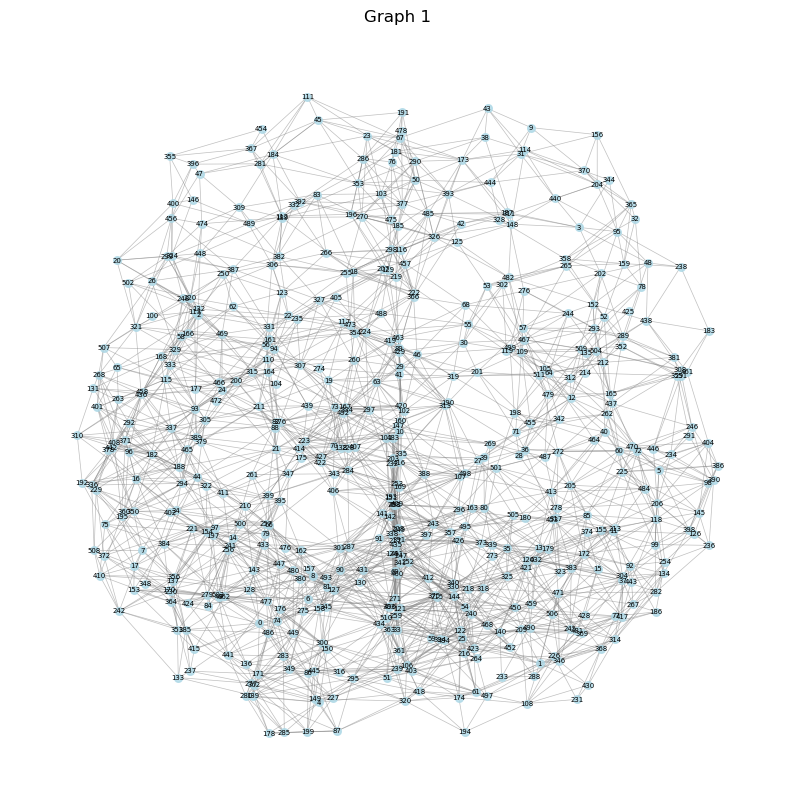

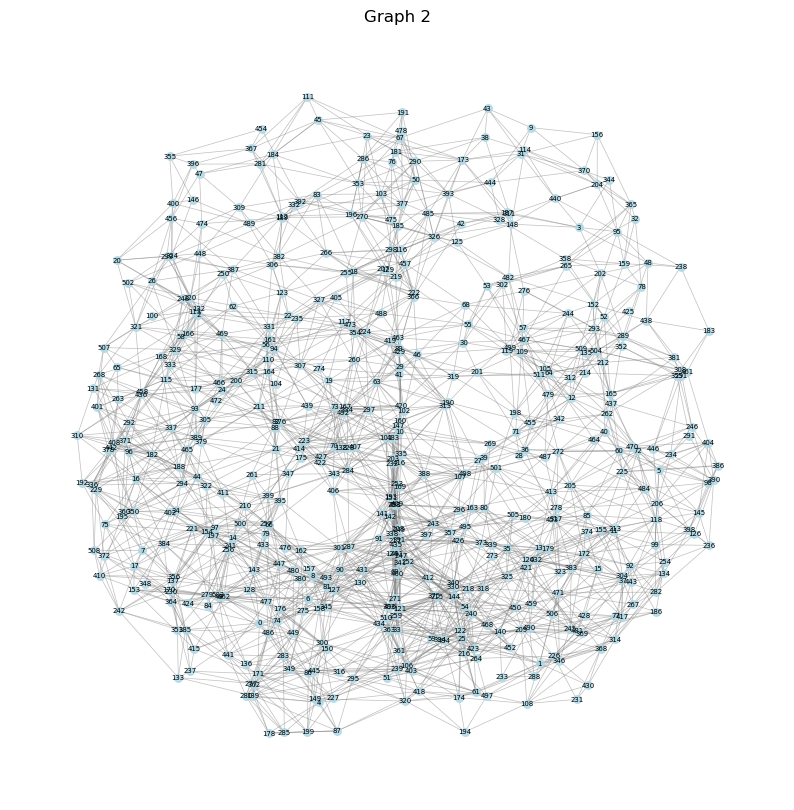

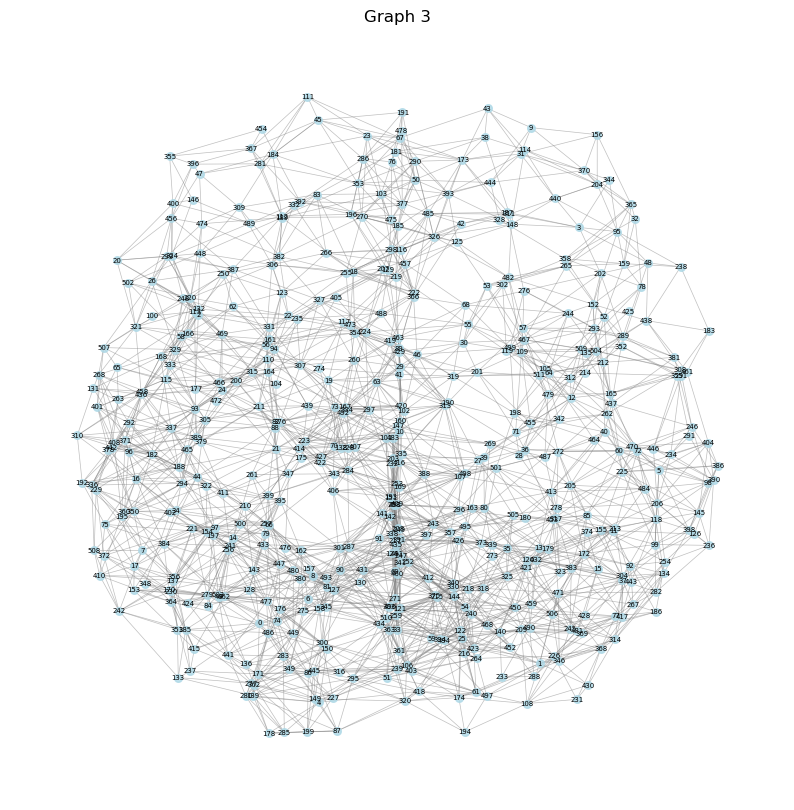

In [181]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch

# Function to visualize a graph using ROI anatomical coordinates
def visualize_graph(graph, disconnected_nodes=None, title="Graph Visualization"):
    G = to_networkx(graph, edge_attrs=["edge_attr"])
    G = G.to_undirected()

    # Extract coordinates from graph.pos → [num_nodes, 3]
    coords = graph.pos.cpu().numpy() if isinstance(graph.pos, torch.Tensor) else graph.pos
    pos = {i: coords[i, :2] for i in range(coords.shape[0])}  # Use only X-Y for 2D layout

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(
        G, pos, 
        nodelist=[n for n in G.nodes if n not in disconnected_nodes],
        node_size=30, node_color="lightblue", alpha=0.8
    )
    if disconnected_nodes:
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=disconnected_nodes, 
            node_size=30, node_color="red", alpha=0.8
        )
    nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.5, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=5)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Visualize first 3 graphs with anatomical layout and highlight disconnected nodes
for i in range(3):
    visualize_graph(all_graphs[i], disconnected_nodes=disconnected_nodes, title=f"Graph {i+1}")


In [17]:
# Filter out graphs with x shape (512, 316)
all_graphs = [graph for graph in all_graphs if graph.x.shape != (512, 316)]

In [15]:
len(all_graphs)

21316

In [19]:
torch.save(all_graphs, 'all_graphs_512_timepoint.pt')

print(f'Done saving all graphs for {len(signals_ocd.files) + len(signals_hc.files)} patients')

Done saving all graphs for 51 patients


In [3]:
import torch
all_graphs = torch.load('all_graphs_time_emb.pt')

/tmp/ipykernel_1462742/1261760783.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_graphs = torch.load('all_graphs_time_emb.pt')
/gpfs/gibbs/project/krishnaswamy_smit

In [4]:
all_graphs

[Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=0),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=1),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=2),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=3),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=4),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=5),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=6),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=7),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=8),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=9),
 Data(x=[512, 17], edge_index=[2, 5460], edge_attr=[5460], y=[1], pos=[512, 3], time=10),
 Data(x=[512, 17], e

In [28]:
import torch
import numpy as np
from torch_geometric.utils import to_dense_adj
from sklearn.cluster import SpectralClustering
import pandas as pd
from tqdm import tqdm

# Load your 51 graphs (each graph should have 512 nodes)
graphs = torch.load("all_graphs_FC.pt")  # list of Data objects

num_nodes = 512
adj_accum = torch.zeros((num_nodes, num_nodes))

# Step 1: Average adjacency matrix across graphs
for g in tqdm(graphs, desc="Averaging adjacencies"):
    adj = to_dense_adj(g.edge_index, edge_attr=g.edge_attr, max_num_nodes=num_nodes)[0]
    adj_accum += adj

adj_mean = adj_accum / len(graphs)  # shape (512, 512)

# Step 2: Spectral Clustering
adj_numpy = adj_mean.numpy()
num_clusters = 60
spectral = SpectralClustering(
    n_clusters=num_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=0
)
cluster_assignments = spectral.fit_predict(adj_numpy)

# Step 3: Write wide-format CSV
clusters_dict = {f"Cluster {i}": [] for i in range(num_clusters)}
for node, cluster in enumerate(cluster_assignments):
    clusters_dict[f"Cluster {cluster}"].append(float(node))

# Pad columns to same length
max_len = max(len(v) for v in clusters_dict.values())
df_out = pd.DataFrame({k: v + [''] * (max_len - len(v)) for k, v in clusters_dict.items()})
df_out.to_csv("node_cluster_assignments_FC.csv", index=False)
print("Saved node_cluster_assignments_FC.csv")


/tmp/ipykernel_1108504/202890978.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load("all_graphs_FC.pt")  # list of Data objects
Averaging adjacencies: 1

Saved node_cluster_assignments_FC.csv


In [29]:
clusters_dict

{'Cluster 0': [178.0, 186.0, 194.0, 231.0, 285.0, 362.0, 430.0, 497.0],
 'Cluster 1': [0.0,
  6.0,
  34.0,
  48.0,
  61.0,
  74.0,
  85.0,
  86.0,
  92.0,
  95.0,
  118.0,
  130.0,
  143.0,
  145.0,
  149.0,
  152.0,
  154.0,
  171.0,
  204.0,
  212.0,
  213.0,
  216.0,
  218.0,
  240.0,
  245.0,
  249.0,
  254.0,
  267.0,
  275.0,
  289.0,
  314.0,
  320.0,
  323.0,
  346.0,
  365.0,
  383.0,
  385.0,
  394.0,
  397.0,
  412.0,
  432.0,
  438.0,
  452.0,
  459.0,
  484.0,
  493.0,
  496.0,
  506.0,
  511.0],
 'Cluster 2': [505.0],
 'Cluster 3': [451.0],
 'Cluster 4': [343.0],
 'Cluster 5': [352.0],
 'Cluster 6': [208.0],
 'Cluster 7': [55.0],
 'Cluster 8': [217.0],
 'Cluster 9': [433.0],
 'Cluster 10': [12.0,
  70.0,
  163.0,
  165.0,
  182.0,
  225.0,
  255.0,
  268.0,
  292.0,
  294.0,
  308.0,
  327.0,
  337.0,
  358.0,
  376.0,
  389.0,
  404.0,
  436.0,
  461.0,
  466.0,
  470.0,
  509.0],
 'Cluster 11': [500.0],
 'Cluster 12': [406.0],
 'Cluster 13': [11.0,
  28.0,
  105.0,
  11

/tmp/ipykernel_1108504/2751871333.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", num_clusters)


<Figure size 1000x800 with 0 Axes>

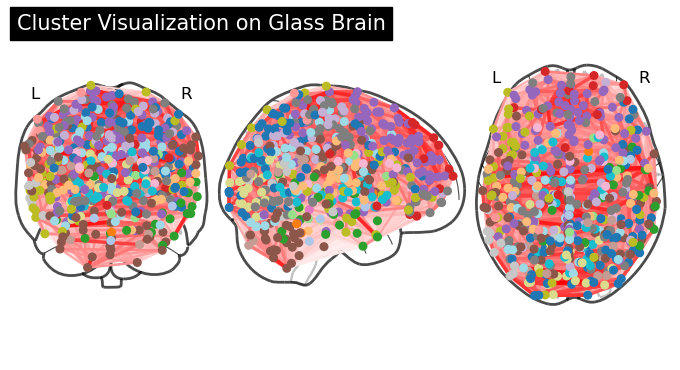

In [30]:
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt

# Extract coordinates from the `coords` variable
coords_3d = coords  # shape: (128, 3)

# Assign cluster labels to each node
cluster_colors = np.array(cluster_assignments)  # shape: (512,)

# Create a color map for the clusters
num_clusters = len(np.unique(cluster_colors))
cmap = plt.cm.get_cmap("tab20", num_clusters)

# Use the averaged adjacency matrix from the graphs
adjacency_matrix = adj_mean  # shape: (512, 512)

# Plot the clusters on a glass brain map
fig = plt.figure(figsize=(10, 8))
plotting.plot_connectome(
    adjacency_matrix=adjacency_matrix,
    node_coords=coords_3d,
    node_color=[cmap(cluster_colors[i]) for i in range(len(cluster_colors))],
    node_size=30,
    display_mode="ortho",
    title="Cluster Visualization on Glass Brain"
)
plt.show()

# Baselines

In [24]:
# Baseline: Logistic regression on mean pooled x
X = torch.stack([g.x.mean(dim=0) for g in all_graphs])
y = torch.tensor([g.y.item() for g in all_graphs])

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
print("Baseline accuracy:", clf.score(X_test, y_test))


Baseline accuracy: 0.5485459662288931


In [ ]:
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim

# Prepare data
X = torch.stack([g.x.mean(dim=0) for g in all_graphs])  # Mean pooled x
y = torch.tensor([g.y.item() for g in all_graphs])  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(y.unique())
model = MLP(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)
    accuracy = (y_pred == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

In [25]:
all_graphs[0].x

tensor([[ 8.7948e-02],
        [ 1.1291e-01],
        [ 4.1282e+00],
        [ 3.3894e+00],
        [-2.0282e+00],
        [ 1.2016e+00],
        [ 2.8080e-01],
        [ 1.5946e+00],
        [-1.4297e+00],
        [ 1.9453e+00],
        [ 2.3440e+00],
        [-9.1216e-01],
        [ 1.2474e+00],
        [ 7.2971e-01],
        [-5.0558e-01],
        [ 1.1362e+00],
        [ 2.8681e+00],
        [ 1.9669e+00],
        [ 1.2983e+00],
        [ 3.5560e+00],
        [ 4.5029e+00],
        [ 1.2419e+00],
        [ 6.5496e-01],
        [ 4.2461e+00],
        [-7.7356e-01],
        [-1.0990e+00],
        [ 9.8837e-01],
        [ 4.8573e+00],
        [ 1.6735e-02],
        [ 1.6881e+00],
        [-6.5625e-01],
        [ 2.1350e+00],
        [ 1.9196e-01],
        [ 1.5822e+00],
        [ 6.2640e+00],
        [ 9.6993e-01],
        [ 1.8890e+00],
        [ 6.8037e-01],
        [ 1.1435e-01],
        [ 2.9130e+00],
        [ 3.2040e+00],
        [ 4.9100e+00],
        [ 3.5917e+00],
        [ 5

In [26]:
len(all_graphs)

21316